In [15]:
import numpy as np
import pickle as pkl
#import pickle5 as pkl
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import pandas as pd
import mdtraj as md
from scipy.interpolate import CubicSpline

In [5]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [ ]:
#Loads SAXS intensities calculated from simulations - in BME format
def load_sim_SAXS(calc_file):
    calc_data = np.array([[float(x) for x in line.split()[1:]] for line in open(calc_file) if("#" not in line)])
    return np.array(calc_data)

#Loads experimental SAXS q, I and err - in BME format
def load_exp_SAXS(exp_file):
    q, I, err = np.genfromtxt(exp_file, usecols=(0,1,2), skip_header=0, unpack=True)
    return np.array(q), np.array(I), np.array(err)

def save_pickle(filename, pickle_obj):
    with open(filename, 'wb') as f:
        pkl.dump(pickle_obj, f)

def load_pickle(filename):
    with open(filename, 'rb') as f:
        loaded_obj = pkl.load(f)
        
    return loaded_obj

#Fit calc data profiles scale and offset with linear regression
def fit_scale_offset(Iaverage_sim, I_exp, err_exp):
    #Get weight for each point based on exp error
    sample_weight=1.0/(err_exp**2)
    
    #Linear regression
    reg = LinearRegression(fit_intercept=True).fit(Iaverage_sim.reshape(-1,1),I_exp.reshape(-1,1),sample_weight=sample_weight)
    r_value = reg.score(Iaverage_sim.reshape(-1,1),I_exp.reshape(-1,1),sample_weight=sample_weight)
    slope,intercept = reg.coef_[0],reg.intercept_
    
    Iaverage_sim_fit = Iaverage_sim*slope+intercept
    
    return Iaverage_sim_fit, slope, intercept, r_value

def get_chi2(Iaverage_sim, I_exp, err_exp):
    
    chi2 = np.average(np.square((Iaverage_sim-I_exp)/err_exp))
    
    return chi2

def load_sim_PREs(calc_file):
    calc_data = np.array([[float(x) for x in line.split()[1:]] for line in open(calc_file) if("#" not in line)])
    calc_data_header = np.array([[float(x) for x in line.split()[2:]] for line in open(calc_file) if("#" in line)])

    return calc_data, calc_data_header

# SAXS reweighting

<>:12: SyntaxWarning: invalid escape sequence '\p'
<>:13: SyntaxWarning: invalid escape sequence '\c'
<>:12: SyntaxWarning: invalid escape sequence '\p'
<>:13: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_1273566/1878069152.py:12: SyntaxWarning: invalid escape sequence '\p'
  plt.xlabel('$\phi_{eff}$', fontsize=20)
/tmp/ipykernel_1273566/1878069152.py:13: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel('$\chi^2_r$', fontsize=20)


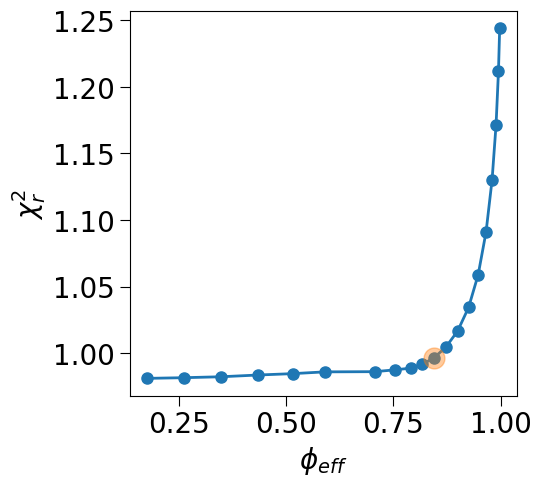

In [7]:
theta_sel = 10

reweighting_results = load_pickle('BME_rew_SAXSonly/BME_results.pkl')

fig = plt.figure(figsize=(5,5))

plt.plot(reweighting_results['phi'], reweighting_results['chi2'], 'o-', lw=2, ms=8)

theta_sel_val = reweighting_results['theta'][theta_sel]
plt.plot(reweighting_results['phi'][theta_sel], reweighting_results['chi2'][theta_sel], 'o', ms=15, alpha=0.4, label=f'{theta_sel_val}')

plt.xlabel('$\phi_{eff}$', fontsize=20)
plt.ylabel('$\chi^2_r$', fontsize=20)
plt.tick_params(colors='black', direction='out', length=7, labelsize=20)

weights = reweighting_results['weights'][theta_sel]
save_pickle('BME_rew_SAXSonly/weights.pkl', weights)

fig.savefig('figures/theta_scan_SAXSonly.png', bbox_inches='tight', pad_inches=1, dpi=400)
fig.savefig('figures/theta_scan_SAXSonly.pdf', bbox_inches='tight', pad_inches=1, dpi=400)

with open('data_files/lambda_scan.dat', 'w') as f:
    f.write('#phieff\tchi2r\n')
    for phi, chi2 in zip(reweighting_results['phi'], reweighting_results['chi2']):
        f.write(f'{phi}\t{chi2}\n')

In [8]:
SAXS = load_sim_SAXS('BME_rew_SAXSonly/calc_SAXS_BME.dat')

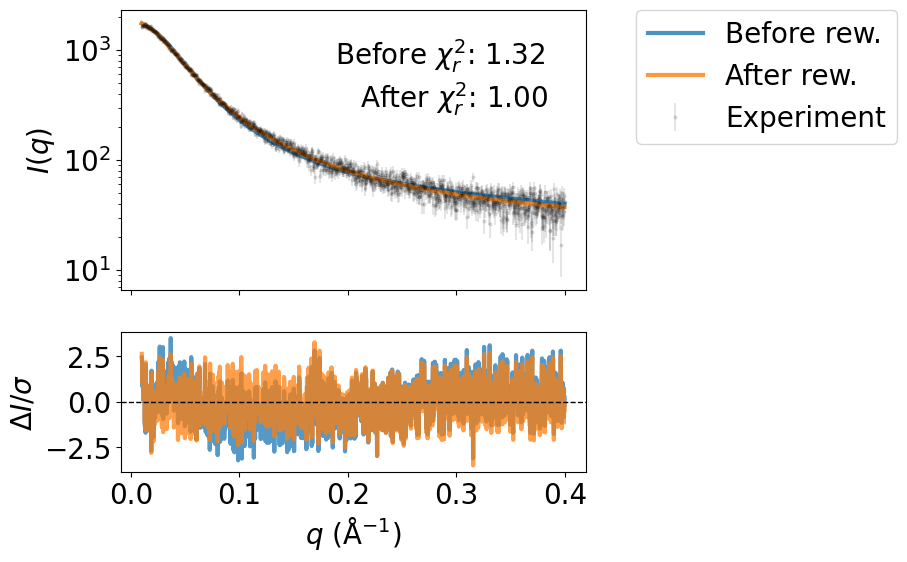

In [9]:
SAXS_avg = np.average(SAXS, axis=0)
SAXS_avg_rew = np.average(SAXS, axis=0, weights=weights)

q, I_exp, err_exp = load_exp_SAXS('BME_rew_SAXSonly/SAXS_Nov2023_trimmed_BME.dat')
q *= 0.1

SAXS_avg_scaleoffset, slope, intercept, r_value = fit_scale_offset(SAXS_avg, I_exp, err_exp)
SAXS_avg_rew_scaleoffset, slope, intercept, r_value = fit_scale_offset(SAXS_avg_rew, I_exp, err_exp)

chi2 = get_chi2(SAXS_avg_scaleoffset, I_exp, err_exp)
chi2_rew = get_chi2(SAXS_avg_rew_scaleoffset, I_exp, err_exp)

residuals = (SAXS_avg_scaleoffset-I_exp)/err_exp
residuals_rew = (SAXS_avg_rew_scaleoffset-I_exp)/err_exp

#SAXS figure
fig, ax = plt.subplots(figsize = (6,6), nrows=2, sharex='col', sharey='row', gridspec_kw={'height_ratios': [4, 2]})

ax[0].errorbar(q, I_exp, yerr=err_exp, fmt='o', markersize=2, color='black', alpha=0.1, label='Experiment')
ax[0].plot(q, SAXS_avg_scaleoffset, linewidth=3, label="Before rew.", alpha=0.8, color=colors[0])
ax[0].plot(q, SAXS_avg_rew_scaleoffset, linewidth=3, label="After rew.", alpha=0.8, color=colors[1])

ax[0].semilogy()
ax[0].set_ylabel('$I(q)$', fontsize=20)
ax[0].legend(fontsize=20, bbox_to_anchor=(1.7, 1.05))
ax[0].text(0.92,0.65, f'Before $χ^2_r$: {chi2:.2f} \nAfter $χ^2_r$: {chi2_rew:.2f}', fontsize=20, transform=ax[0].transAxes, horizontalalignment='right')

for j in range(len(ax)):
    ax[j].tick_params(axis='both', which='major', labelsize=20)

ax[1].plot(q, residuals, linewidth=3, color= colors[0], alpha=0.75)
ax[1].plot(q, residuals_rew, linewidth=3, color= colors[1], alpha=0.75)

ax[1].set_ylabel('$ΔI/σ$', fontsize=20)
ax[1].set_xlabel('$q$ (Å$^{-1}$)', fontsize=20)
ax[1].axhline(0, ls='--', linewidth=1, color='black')

fig.savefig('figures/SAXS.png', bbox_inches='tight', pad_inches=1, dpi=400)
fig.savefig('figures/SAXS.pdf', bbox_inches='tight', pad_inches=1, dpi=400)

with open('data_files/SAXS.dat', 'w') as f:
    f.write('#q\tI_exp\tdI_exp\tI_sim\tResiduals_sim\tI_sim(rew.)\tResiduals_sim(rew.)\n')
    for i, q_val in enumerate(q):
        f.write(f'{q_val:.8f}\t{I_exp[i]:.5f}\t{err_exp[i]:.5f}\t{SAXS_avg_scaleoffset[i]:.10f}\t{residuals[i]:.10f}\t{SAXS_avg_rew_scaleoffset[i]:.10f}\t{residuals_rew[i]:.10f}\n')

In [10]:
"""
with open('data_files/SAXS_rew_avg.dat', 'w') as f:
    for i,q_val in enumerate(q):
        f.write(f'{q_val*10:.8f}\t{SAXS_avg_rew_scaleoffset[i]:.8f}\n')
"""

# Calculate P(r)

# PRE comparison

In [14]:
PRE_results = load_pickle('PREs/PREs_INEPT5.4ms/ANAC046_PREs.pkl')

In [15]:
PRE_results

,ANAC046
calcPREs,label 45 87 151 residue ...
chi2,256.677777
expPREs,value erro...
tau_c,12.0


In [16]:
PRE_SAXSrew_results= load_pickle('PREs/PREs_weighted_INEPT5.4ms/ANAC046_PREs.pkl')

In [17]:
PRE_SAXSrew_results

,ANAC046
calcPREs,label 45 87 151 residue ...
chi2,260.956862
expPREs,value erro...
tau_c,12.0


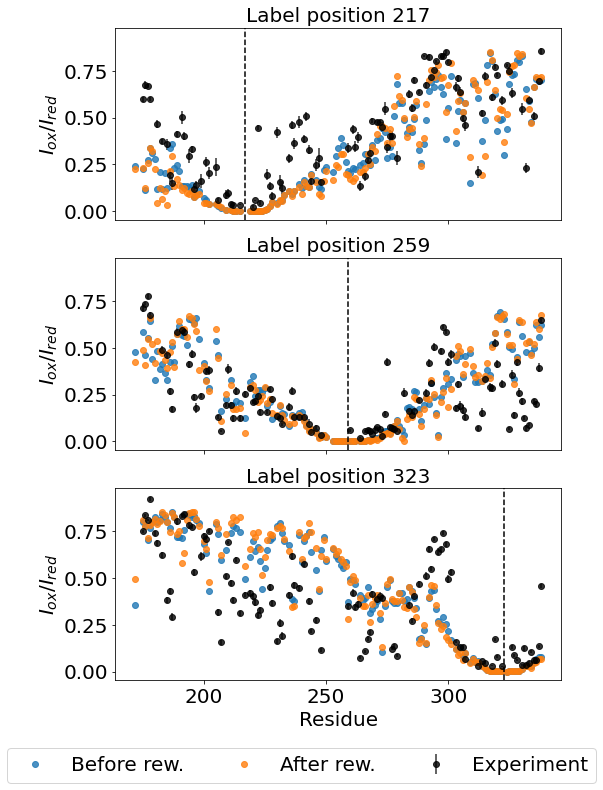

In [46]:
resis = np.arange(0,167)
labels = [45, 87, 151]

resis_plot = resis+172

fig, ax = plt.subplots(figsize = (8, 12), nrows=3, sharex='all', sharey='all')


for i,label in enumerate(labels):
        
    ax[i].errorbar(resis_plot, PRE_results['ANAC046']['expPREs']['value'][label], yerr=PRE_results['ANAC046']['expPREs']['error'][label], fmt='o', c='black', alpha=0.8, label='Experiment')
    
    ax[i].plot(resis_plot, PRE_results['ANAC046']['calcPREs'][label], 'o', c=colors[0], alpha=0.8, label='Before rew.')
    ax[i].plot(resis_plot, PRE_SAXSrew_results['ANAC046']['calcPREs'][label], 'o', c=colors[1], alpha=0.8, label='After rew.')
    
    label_plot = label + 172
    ax[i].axvline(label_plot, c='black', ls='--')
    
    ax[i].set_ylabel('$I_{ox}/I_{red}$', fontsize=20)
    ax[i].tick_params(axis='both', which='major', labelsize=20)
    ax[i].set_yticks(np.arange(0.0, 0.76, 0.25))
    ax[i].set_title(f'Label position {label_plot}', fontsize=20)
    
    with open(f'data_files/PREs_label{label_plot}.dat', 'w') as f:
        f.write('#Resi\tPRE_exp\tdPRE_exp\tPRE_sim\tPRE_sim(rew.)\n')
        
        PRE_exp = PRE_results['ANAC046']['expPREs']['value'][label].values
        PRE_exp_err = PRE_results['ANAC046']['expPREs']['error'][label].values
        PRE_sim = PRE_results['ANAC046']['calcPREs'][label].values
        PRE_sim_rew = PRE_SAXSrew_results['ANAC046']['calcPREs'][label].values
        
        for j,resi in enumerate(resis_plot):
            f.write(f'{resi}\t{PRE_exp[j]}\t{PRE_exp_err[j]}\t{PRE_sim[j]}\t{PRE_sim_rew[j]}\n')

ax[i].set_xlabel('Residue', fontsize=20)
ax[i].legend(fontsize=20, ncol=3, bbox_to_anchor=(1.1, -0.3))

fig.savefig(f'figures/PREs.png', bbox_inches='tight', pad_inches=1, dpi=400)
fig.savefig(f'figures/PREs.pdf', bbox_inches='tight', pad_inches=1, dpi=400)
